In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 16.7 MB/s eta 0:00:00


In [150]:
# utilities
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import zipfile
import os
import re

# nlp
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.scripts.glove2word2vec import glove2word2vec

# sklearn
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

# keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models

# transformers
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [153]:
# load datasets

txt_train = pd.read_fwf('https://github.com/XL2248/MSCTD/raw/main/MSCTD_data/ende/english_train.txt', header=None)
txt_train.columns = ['sentences']
lbl_train = pd.read_fwf('https://github.com/XL2248/MSCTD/raw/main/MSCTD_data/ende/sentiment_train.txt', header=None)
lbl_train.columns = ['labels']
train_set = pd.concat([txt_train, lbl_train], axis=1)

txt_val = pd.read_fwf('https://github.com/XL2248/MSCTD/raw/main/MSCTD_data/ende/english_dev.txt', header=None)
txt_val.columns = ['sentences']
lbl_val = pd.read_fwf('https://github.com/XL2248/MSCTD/raw/main/MSCTD_data/ende/sentiment_dev.txt', header=None)
lbl_val.columns = ['labels']
val_set = pd.concat([txt_val, lbl_val], axis=1)

txt_test = pd.read_fwf('https://github.com/XL2248/MSCTD/raw/main/MSCTD_data/ende/english_test.txt', header=None)
txt_test.columns = ['sentences']
lbl_test = pd.read_fwf('https://github.com/XL2248/MSCTD/raw/main/MSCTD_data/ende/sentiment_test.txt', header=None)
lbl_test.columns = ['labels']
test_set = pd.concat([txt_test, lbl_test], axis=1)

In [88]:
train_set.head()

,sentences,labels
0,Okay. I'm confused.,0
1,"You don't care if I go to Paris with Jane,",0
2,"I'm sorry. I have to tell you something,",1
3,I have to go.,1
4,I'm an accessory to murder.,1


In [154]:
val_set.head()

,sentences,labels
0,He diagnosed Andy with growing pains.,0
1,"But, you know, I grew up,",0
2,Your pain is dramatic to me.,1
3,Andy. your mom's right.,0
4,It's a good thing that you came.,0


In [155]:
test_set.head()

,sentences,labels
0,With this asshole?,1
1,"Two guys walk in, one walks out.",1
2,"I'm not happy about it either, okay? At all.",1
3,"But, for now, it's done.",1
4,You're on admin leave until they make a determ...,0


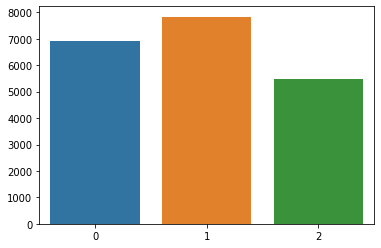

In [89]:
sns.barplot(x=train_set.labels.value_counts().index, y=train_set.labels.value_counts().values);

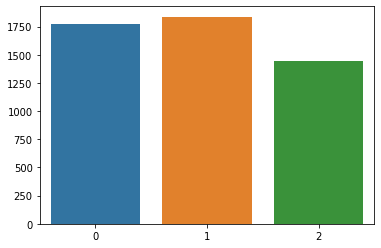

In [146]:
sns.barplot(x=val_set.labels.value_counts().index, y=val_set.labels.value_counts().values);

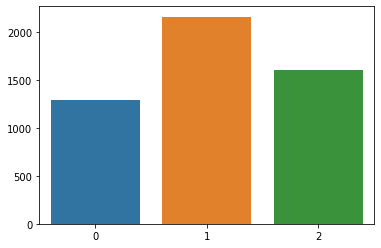

In [148]:
sns.barplot(x=test_set.labels.value_counts().index, y=test_set.labels.value_counts().values);

In [105]:
def clean_text(sentence):
  sentence = str(sentence).lower()
  sentence = re.sub('[^a-z]',' ',sentence)
  sentence = word_tokenize(sentence)
  stop_words = stopwords.words('english')
  sentence = [i for i in sentence if i not in stop_words]
  sentence = [i for i in sentence if len(i)>1]
  sentence = ' '.join(sentence)
  return sentence

In [156]:
train_set['sentences'] = train_set['sentences'].apply(clean_text)
val_set['sentences'] = val_set['sentences'].apply(clean_text)
test_set['sentences'] = test_set['sentences'].apply(clean_text)

In [92]:
train_set.head()

,sentences,labels
0,okay confused,0
1,care go paris jane,0
2,sorry tell something,1
3,go,1
4,accessory murder,1


In [152]:
val_set.head()

,sentences,labels
0,diagnosed andy growing pains,0
1,know grew,0
2,pain dramatic,1
3,andy mom right,0
4,good thing came,0


In [157]:
test_set.head()

,sentences,labels
0,asshole,1
1,two guys walk one walks,1
2,happy either okay,1
3,done,1
4,admin leave make determination battery,0


In [107]:
train_sentences = train_set.sentences.values
train_labels = train_set.labels.values

val_sentences = val_set.sentences.values
val_labels = val_set.labels.values

test_sentences = test_set.sentences.values
test_labels = test_set.labels.values

## TF IDF

In [108]:
tf_idf = TfidfVectorizer()
train_tf_idf = tf_idf.fit_transform(train_sentences).astype('float16')
val_tf_idf = tf_idf.transform(val_sentences).astype('float16')
test_tf_idf = tf_idf.transform(test_sentences).astype('float16')

In [109]:
lr = LogisticRegression(solver='newton-cg')
lr.fit(train_tf_idf, train_labels)

LogisticRegression(solver='newton-cg')

In [110]:
y_preds = lr.predict(test_tf_idf)
print('f1_score: ', f1_score(test_labels, y_preds, average='macro'))
print('accuracy: ', accuracy_score(test_labels, y_preds))

f1_score:  0.4782599360247839
accuracy:  0.4910203276100257


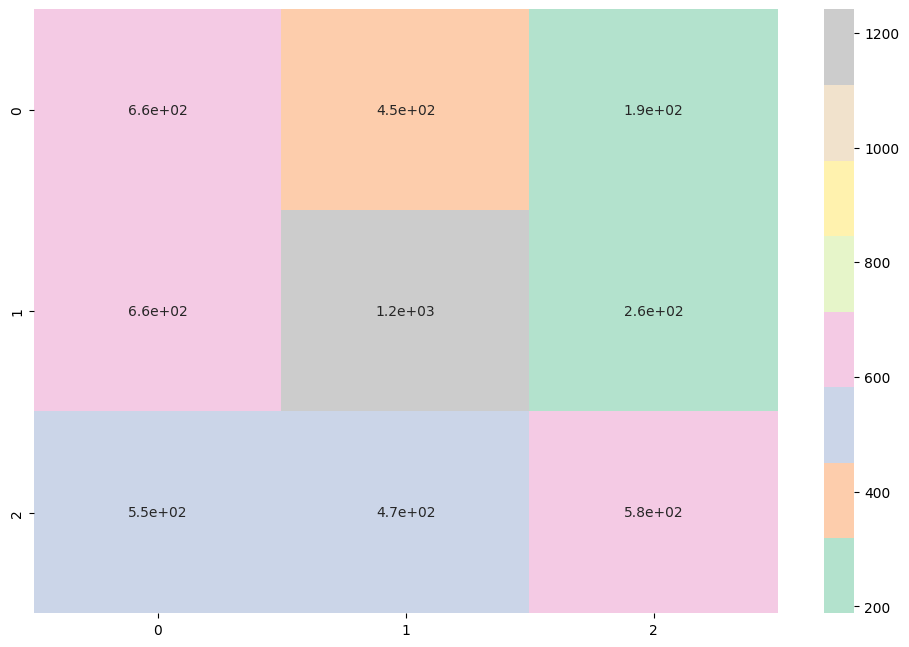

In [111]:
cm = confusion_matrix(test_labels, y_preds)
plt.figure(figsize=(12,8), dpi=100)
sns.heatmap(cm, annot=True, cmap='Pastel2')
plt.show()

In [126]:
def model():
  input = layers.Input(shape=(train_tf_idf.shape[1],))
  x = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(input)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dropout(0.3)(x)
  output = layers.Dense(3, activation='softmax')(x)

  model = models.Model(input, output)
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [127]:
model = KerasClassifier(build_fn=model, epochs=10, batch_size=128)
model.fit(train_tf_idf, train_labels, validation_data=(val_tf_idf, val_labels))

Epoch 1/10
159/159 [==============================] - 3s 16ms/step - loss: 1.0506 - accuracy: 0.4413 - val_loss: 1.0143 - val_accuracy: 0.4841
Epoch 2/10
159/159 [==============================] - 3s 16ms/step - loss: 0.8659 - accuracy: 0.6104 - val_loss: 1.0540 - val_accuracy: 0.4766
Epoch 3/10
159/159 [==============================] - 3s 17ms/step - loss: 0.6939 - accuracy: 0.7062 - val_loss: 1.1593 - val_accuracy: 0.4778
Epoch 4/10
159/159 [==============================] - 3s 19ms/step - loss: 0.5683 - accuracy: 0.7617 - val_loss: 1.2813 - val_accuracy: 0.4736
Epoch 5/10
159/159 [==============================] - 3s 16ms/step - loss: 0.4765 - accuracy: 0.8010 - val_loss: 1.4248 - val_accuracy: 0.4640
Epoch 6/10
159/159 [==============================] - 3s 16ms/step - loss: 0.3993 - accuracy: 0.8357 - val_loss: 1.5795 - val_accuracy: 0.4655
Epoch 7/10
159/159 [==============================] - 3s 21ms/step - loss: 0.3460 - accuracy: 0.8572 - val_loss: 1.6775 - val_accuracy: 0.4582

In [128]:
y_preds = model.predict(test_tf_idf)
print('f1_score: ', f1_score(test_labels, y_preds, average='macro'))
print('accuracy: ', accuracy_score(test_labels, y_preds))

159/159 [==============================] - 0s 1ms/step
f1_score:  0.4602348727502023
accuracy:  0.47148213933293864


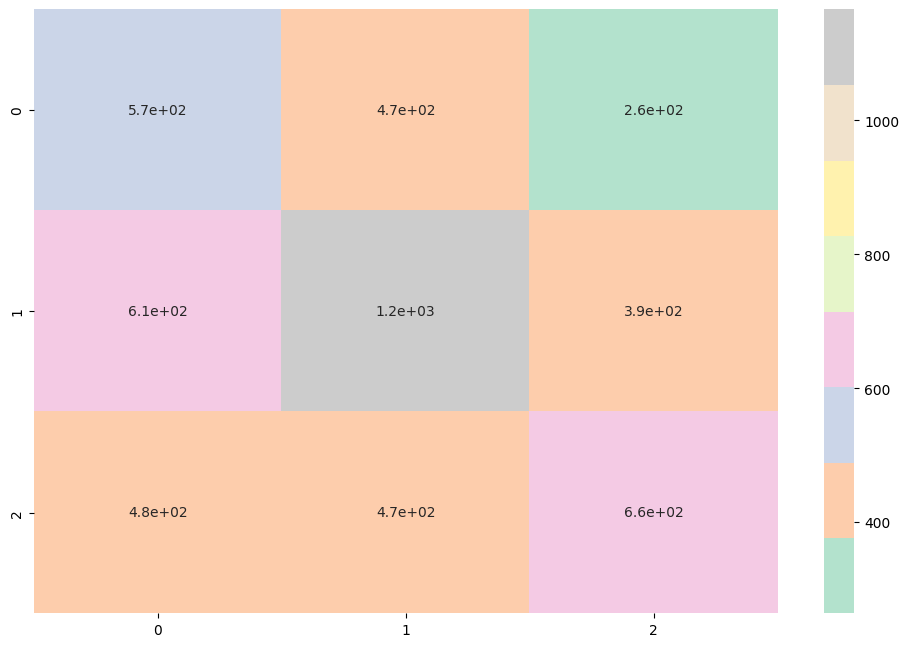

In [129]:
cm = confusion_matrix(test_labels, y_preds)
plt.figure(figsize=(12,8), dpi=100)
sns.heatmap(cm, annot=True, cmap='Pastel2')
plt.show()

## Word2vec simulation

In [ ]:
unique_words = tf_idf.get_feature_names_out()
df_train = pd.DataFrame.sparse.from_spmatrix(train_tf_idf, columns=unique_words)

sentences=[]
for review in train_sentences:
  sentence=[]
  for word in review.split():
    sentence.append(word.lower())
  sentences.append(sentence)

vocab ={v:np.zeros((1,2)) for v in unique_words}
for i, sentence in tqdm(enumerate(sentences)):
  for j in range(len(sentence)):
    svm=SVC(kernel='linear')
    X_train = df_train.iloc[i,:]
    y_train = {k:0 for k in unique_words}
    y_train[sentence[j]] = 1
    try:
      y_train[sentence[j+1]] =1
    except:
      pass
    try:
      y_train[sentence[j-1]] = 1
    except:
      pass
    try:
      y_train[sentence[j+2]] =1
    except:
      pass
    try:
      y_train[sentence[j-2]] =1
    except:
      pass
    svm.fit(np.array(X_train).reshape(-1,1), list(y_train.values()))
    w = list(svm.coef_[0])
    b = list(svm.intercept_)[0]
    w.append(b)
    vocab[sentence[j]] += w

0it [00:00, ?it/s]

In [ ]:
for word in unique_words:
  count = (df_train[word] != 0).sum()
  vocab[word]/=count

In [ ]:
df = pd.DataFrame({word:list(vocab[word]) for word in unique_words}, index=[0])
df.to_csv('vectors.csv')

In [ ]:
for sentence in sentences:
  for i,word in enumerate(sentence):
    sentence[i] = vocab[word][0]

In [ ]:
word2vec_data = np.array([
    [[0.0,0.0] for i in range(len(sentences))] for j in range(10)
    ]).reshape(20240, 10, 2)

In [ ]:
for i,sentence in enumerate(sentences):
  for j,word in enumerate(sentence):
    word2vec_data[i,j,0] = word[0]
    word2vec_data[i,j,1] = word[1]

In [ ]:
input = layers.Input(shape=((10, 2)))
x = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(input)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = layers.Flatten()(x)
output = layers.Dense(3, activation='softmax')(x)
model = models.Model(input, output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(word2vec_data, train_labels, epochs=5, batch_size=128)

Epoch 1/5
159/159 [==============================] - 7s 37ms/step - loss: 1.1576 - accuracy: 0.3584
Epoch 2/5
159/159 [==============================] - 9s 59ms/step - loss: 1.0953 - accuracy: 0.3800
Epoch 3/5
159/159 [==============================] - 7s 44ms/step - loss: 1.0894 - accuracy: 0.3845
Epoch 4/5
159/159 [==============================] - 6s 40ms/step - loss: 1.0889 - accuracy: 0.3783
Epoch 5/5
159/159 [==============================] - 6s 35ms/step - loss: 1.0857 - accuracy: 0.3827


## Glove

In [130]:
!wget --no-check-certificate \
http://nlp.stanford.edu/data/glove.6B.zip \
-O /tmp/glove.6B.zip

with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

f = open('/tmp/glove/glove.6B.50d.txt')

glove_vecs = {}

for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype="float32")
    glove_vecs[word] = vec
f.close()

--2023-02-03 09:47:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-03 09:47:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-03 09:47:05--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


In [131]:
all_centences = np.append(train_sentences,val_sentences)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_centences)
word2idx = tokenizer.word_index

In [132]:
glove_embedding_matrix = np.zeros((len(word2idx) + 1, 50))
for word, i in word2idx.items():
  if i < len(word2idx):
    embedding_vector = glove_vecs.get(word)
    if embedding_vector is not None:
      glove_embedding_matrix[i] = embedding_vector

In [ ]:
# maxlen?
texts = []
for text in all_centences:
  sentence = []
  for word in text.split():
    sentence.append(word)
  texts.append(sentence)
maxlen = max(len(i) for i in texts)

In [141]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=maxlen)

val_sequences = tokenizer.texts_to_sequences(val_sentences)
val_padded = pad_sequences(val_sequences, maxlen=maxlen)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=maxlen)

In [142]:
def model():
  model = models.Sequential()
  model.add(layers.Embedding(input_dim=glove_embedding_matrix.shape[0],
                                    output_dim=glove_embedding_matrix.shape[1],
                                    input_length=maxlen,
                                    weights=[glove_embedding_matrix],
                                    trainable=False))
  model.add(layers.Bidirectional(layers.LSTM(50, recurrent_dropout=0.1, return_sequences=True)))
  model.add(layers.GlobalAveragePooling1D())
  model.add(layers.Dense(50))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(3, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [143]:
model = model()
model.fit(train_padded, train_labels, epochs=10, batch_size=128, validation_data=(val_padded, val_labels))

Epoch 1/10
159/159 [==============================] - 12s 39ms/step - loss: 1.0347 - accuracy: 0.4689 - val_loss: 1.0183 - val_accuracy: 0.4942
Epoch 2/10
159/159 [==============================] - 6s 36ms/step - loss: 0.9978 - accuracy: 0.5100 - val_loss: 0.9970 - val_accuracy: 0.5037
Epoch 3/10
159/159 [==============================] - 6s 36ms/step - loss: 0.9845 - accuracy: 0.5206 - val_loss: 0.9904 - val_accuracy: 0.5039
Epoch 4/10
159/159 [==============================] - 6s 36ms/step - loss: 0.9735 - accuracy: 0.5282 - val_loss: 0.9889 - val_accuracy: 0.5076
Epoch 5/10
159/159 [==============================] - 6s 36ms/step - loss: 0.9656 - accuracy: 0.5352 - val_loss: 1.0020 - val_accuracy: 0.5003
Epoch 6/10
159/159 [==============================] - 6s 36ms/step - loss: 0.9571 - accuracy: 0.5379 - val_loss: 0.9820 - val_accuracy: 0.5131
Epoch 7/10
159/159 [==============================] - 6s 36ms/step - loss: 0.9508 - accuracy: 0.5421 - val_loss: 0.9823 - val_accuracy: 0.511

In [144]:
y_preds = model.predict(test_padded)
y_preds = np.argmax(y_preds, axis=1)
print('f1_score: ', f1_score(test_labels, y_preds, average='macro'))
print('accuracy: ', accuracy_score(test_labels, y_preds))

159/159 [==============================] - 1s 5ms/step
f1_score:  0.4806165477696869
accuracy:  0.5024669429642786


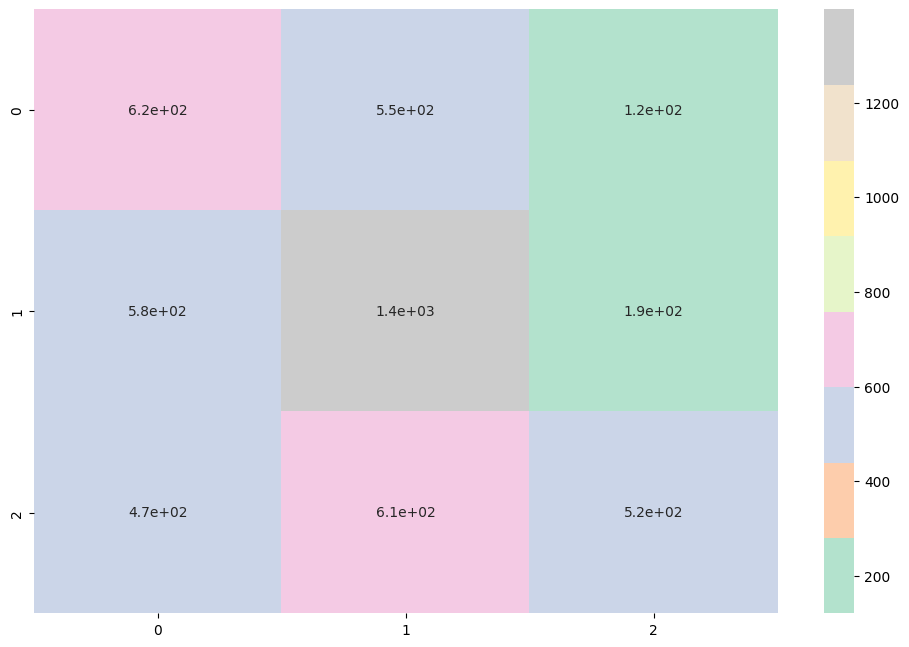

In [145]:
cm = confusion_matrix(test_labels, y_preds)
plt.figure(figsize=(12,8), dpi=100)
sns.heatmap(cm, annot=True, cmap='Pastel2')
plt.show()

## BERT

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def convert_data_to_examples(train, val, test): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None,
                                                          text_a = x['sentences'], 
                                                          label = x['labels']), axis = 1)

    val_InputExamples = val.apply(lambda x: InputExample(guid=None,
                                                          text_a = x['sentences'], 
                                                          label = x['labels']), axis = 1,)
    
    test_InputExamples = test.apply(lambda x: InputExample(guid=None,
                                                          text_a = x['sentences'], 
                                                          label = x['labels']), axis = 1,)
  
    return train_InputExamples, val_InputExamples, test_InputExamples

train_InputExamples, val_InputExamples, test_InputExamples = convert_data_to_examples(train_set, val_set, test_set)

In [ ]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=10):
    features = []

    for e in tqdm(examples):
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length,
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True,
            truncation=True)

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],input_dict["token_type_ids"], input_dict['attention_mask'])
        features.append(InputFeatures( input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label) )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


In [ ]:
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

val_data = convert_examples_to_tf_dataset(list(val_InputExamples), tokenizer)
val_data = val_data.shuffle(100).batch(32)

test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
test_data = test_data.shuffle(100).batch(32)

  0%|          | 0/20240 [00:00<?, ?it/s]

  0%|          | 0/5063 [00:00<?, ?it/s]

  0%|          | 0/5067 [00:00<?, ?it/s]

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=10, validation_data=(val_data))

Epoch 1/10
1266/1266 [==============================] - 234s 166ms/step - loss: 1.0784 - accuracy: 0.4334 - val_loss: 1.1331 - val_accuracy: 0.3630
Epoch 2/10
1266/1266 [==============================] - 156s 123ms/step - loss: 1.0980 - accuracy: 0.4006 - val_loss: 1.1174 - val_accuracy: 0.3630
Epoch 3/10
1266/1266 [==============================] - 155s 122ms/step - loss: 1.0963 - accuracy: 0.3987 - val_loss: 1.1332 - val_accuracy: 0.3630
Epoch 4/10
1266/1266 [==============================] - 155s 123ms/step - loss: 1.0977 - accuracy: 0.3965 - val_loss: 1.1342 - val_accuracy: 0.3630
Epoch 5/10
1266/1266 [==============================] - 156s 123ms/step - loss: 1.0968 - accuracy: 0.3952 - val_loss: 1.1314 - val_accuracy: 0.3630
Epoch 6/10
1266/1266 [==============================] - 156s 123ms/step - loss: 1.0965 - accuracy: 0.3970 - val_loss: 1.1311 - val_accuracy: 0.3630
Epoch 7/10
1266/1266 [==============================] - 155s 122ms/step - loss: 1.0965 - accuracy: 0.3950 - val_

In [ ]:
accuracy = model.evaluate(test_data)
print('accuracy: ', accuracy[1])

accuracy:  0.4268798232078552
